# Tracking with iTPC sector in Run 18

A question regarding a deficiency in tracks in the iTPC sector 20 was raised and
documented on the following page:

https://drupal.star.bnl.gov/STAR/blog/lisa/phi-distributions-not-understood-isobar-runs

We follow up on this issue


In [26]:
import os
import fnmatch
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Configure matplotlib
mpl.rcParams['text.usetex'] = True

In [27]:
def pseudorapidity(x, y, z):
    mag = np.sqrt(x**2 + y**2 + z**2)
    costheta = np.ones_like(x)
    costheta = np.divide(z, mag, out=costheta, where=mag!=0)
    frac = np.full_like(x, np.nan)
    frac = np.divide(1-costheta, 1+costheta, out=frac, where=np.abs(costheta)<1)
    return -0.5 * np.log(frac)

In [28]:
TPC_SECTOR_DELTA_PHI = 2*np.pi/12
TPC_START = 2*TPC_SECTOR_DELTA_PHI + TPC_SECTOR_DELTA_PHI/2
TPC_END   = TPC_START - 2*np.pi
TPC_EDGES = np.linspace(TPC_START, TPC_END, 13)
# Change range to [-pi, pi]
TPC_EDGES = (TPC_EDGES + np.pi) % (2*np.pi) - np.pi
TPC_EDGE_PAIRS = list(zip(TPC_EDGES, TPC_EDGES[1:]))
TPC_SECTORS_WEST = dict(zip( np.arange(1, 13), TPC_EDGE_PAIRS))
TPC_SECTORS_EAST = dict(zip( [23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 24], TPC_EDGE_PAIRS))

In [29]:
def draw_tpc_edges(axes, line_color='C1'):
    ylimits = axes.get_ylim()
    for sec, (sec_max, sec_min) in TPC_SECTORS_EAST.items():
        axes.plot([sec_max, sec_max], ylimits, f'{line_color}-', lw=0.5)
        axes.text(sec_max - 0.8*TPC_SECTOR_DELTA_PHI, ylimits[1]*0.5,
                  f'{sec}', color=f'{line_color}')

In [30]:
branches = {
    'ppx':  'Track.mPMomentum.mX1',
    'ppy':  'Track.mPMomentum.mX2',
    'ppz':  'Track.mPMomentum.mX3',
    'gpx':  'Track.mGMomentum.mX1',
    'gpy':  'Track.mGMomentum.mX2',
    'gpz':  'Track.mGMomentum.mX3',
    'ox':  'Track.mOrigin.mX1',
    'oy':  'Track.mOrigin.mX2',
    'oz':  'Track.mOrigin.mX3',
    'nhits':  'Track.mNHitsFit',
    #'nhmax':  'Track.mNHitsMax',
    'chi2':  'Track.mChi2',
    #'topo':  'Track.mTopologyMap[2]'
}

path = 'data/'
 
rootfiles = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    #for f in fnmatch.filter(files, 'st_physics_adc_19099001_*.picoDst.root')]
    #for f in fnmatch.filter(files, 'st_physics_adc_1909900[1-7]_*.picoDst.root')]
    for f in fnmatch.filter(files, 'st_physics_adc_1909900*.picoDst.root')]
    #for f in fnmatch.filter(files, 'st_physics_*.picoDst.root')]

print(len(rootfiles), 'file(s)')
#rootfiles

44 file(s)


## Create dataframe with tracks

Apply the following basic selection to reduce the memory footprint (2,695,300)

- track origin in transverse plane < 10 cm
- track origin in z < 50 cm
- track angle w.r.t. xy plane < pi/6 ( 30 degrees)

In [31]:
%%time

cut_counts = {
    'or': 0,
    'oz': 0,
    'polar': 0
}

cut_lambdas = {
    'or': lambda df: np.sqrt(df.ox**2 + df.oy**2) < 10,
    'oz': lambda df: np.abs(df.oz) < 50,
    'polar': lambda df: np.abs(np.arctan2(df.gpz, np.sqrt(df.gpx**2 + df.gpy**2))) < np.pi/6
}

# Create smaller dataframes
def todf(rootfile):
    #print(f'rootfile: {rootfile}')
    tree = uproot.open(rootfile)['PicoDst']
    df = tree.pandas.df(branches.values())
    
    ## Can select specific events for debugging
    ## idx corresponds to [entry, subentry]
    #idx = pd.IndexSlice
    #df = df.loc[ idx[13, :], : ]
    
    # Assign short names to columns
    df.columns = branches.keys()
    
    ss = []
    for cut, lamb in cut_lambdas.items():
        s = lamb(df)
        cut_counts[cut] += s.sum()
        ss.append(s)
    
    df = df.loc[ np.logical_and.reduce(ss) ]
    
    return df

dfs = [todf(rootfile) for rootfile in rootfiles]
df = pd.concat(dfs, keys=np.arange(0, len(dfs)), names=['file'])
df.info(memory_usage='deep')
#df.size()
print(cut_counts)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5426644 entries, (0, 0, 5) to (43, 980, 465)
Data columns (total 11 columns):
ppx      float32
ppy      float32
ppz      float32
gpx      float32
gpy      float32
gpz      float32
ox       float32
oy       float32
oz       float32
nhits    int8
chi2     uint16
dtypes: float32(9), int8(1), uint16(1)
memory usage: 227.7 MB
{'or': 12224090, 'oz': 18079704, 'polar': 10718456}
CPU times: user 1min 42s, sys: 14.8 s, total: 1min 57s
Wall time: 1min 59s


In [32]:
#t2v_index = df.index.droplevel(2).tolist()
#t2v_index = [ i + (0,) for i in t2v_index]
#t2v_index

## Create dataframe with primary vertices

In [33]:
%%time

branches_v = {
    'vx':  'Event.mPrimaryVertex.mX1',
    'vy':  'Event.mPrimaryVertex.mX2',
    'vz':  'Event.mPrimaryVertex.mX3'
}

# Create smaller dataframes
def todf(rootfile):
    #print(f'rootfile: {rootfile}')
    tree = uproot.open(rootfile)['PicoDst']
    df = tree.pandas.df(branches_v.values())
    # Assign short names to columns
    df.columns = branches_v.keys()
    return df

dfs = [todf(rootfile) for rootfile in rootfiles]
df_v = pd.concat(dfs, keys=np.arange(0, len(dfs)), names=['file'])
df_v.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 36703 entries, (0, 0, 0) to (43, 980, 0)
Data columns (total 3 columns):
vx    36703 non-null float32
vy    36703 non-null float32
vz    36703 non-null float32
dtypes: float32(3)
memory usage: 581.7 KB
CPU times: user 4.8 s, sys: 117 ms, total: 4.92 s
Wall time: 5.02 s


In [34]:
#df_v.index = df_v.index.droplevel(2)
#df_v.loc[t2v_index]

In [35]:
# Add more columns
df = df.assign(
    mag=np.sqrt(df.ppx**2 + df.ppy**2 + df.ppz**2),
    ppt=np.sqrt(df.ppx**2 + df.ppy**2),
    gpt=np.sqrt(df.gpx**2 + df.gpy**2),
    tphi=np.arctan2(df.gpy, df.gpx),
    teta=pseudorapidity(df.gpx, df.gpy, df.gpz)
)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5426644 entries, (0, 0, 5) to (43, 980, 465)
Data columns (total 16 columns):
ppx      float32
ppy      float32
ppz      float32
gpx      float32
gpy      float32
gpz      float32
ox       float32
oy       float32
oz       float32
nhits    int8
chi2     uint16
mag      float32
ppt      float32
gpt      float32
tphi     float32
teta     float32
dtypes: float32(14), int8(1), uint16(1)
memory usage: 331.2 MB


## Create selections

In [36]:
is_primary = (df.mag > 0)
print(f'{is_primary.sum()}')
is_primary_east = is_primary & (df.teta < 0) & (df.oz < 0)
print(is_primary_east.sum())
is_primary_west = is_primary & (df.teta > 0) & (df.oz > 0)
print(is_primary_west.sum())
# We are mainly interested in the East side with iTPC sector
points_east = (df.teta < 0) & (df.oz < 0)
print(points_east.sum())
points_west = (df.teta > 0) & (df.oz > 0)
print(points_west.sum())

3681701
998728
837757
1467548
1228009


## Transverse momentum distribution for primary and global tracks

It looks as if some primary tracks do not have 

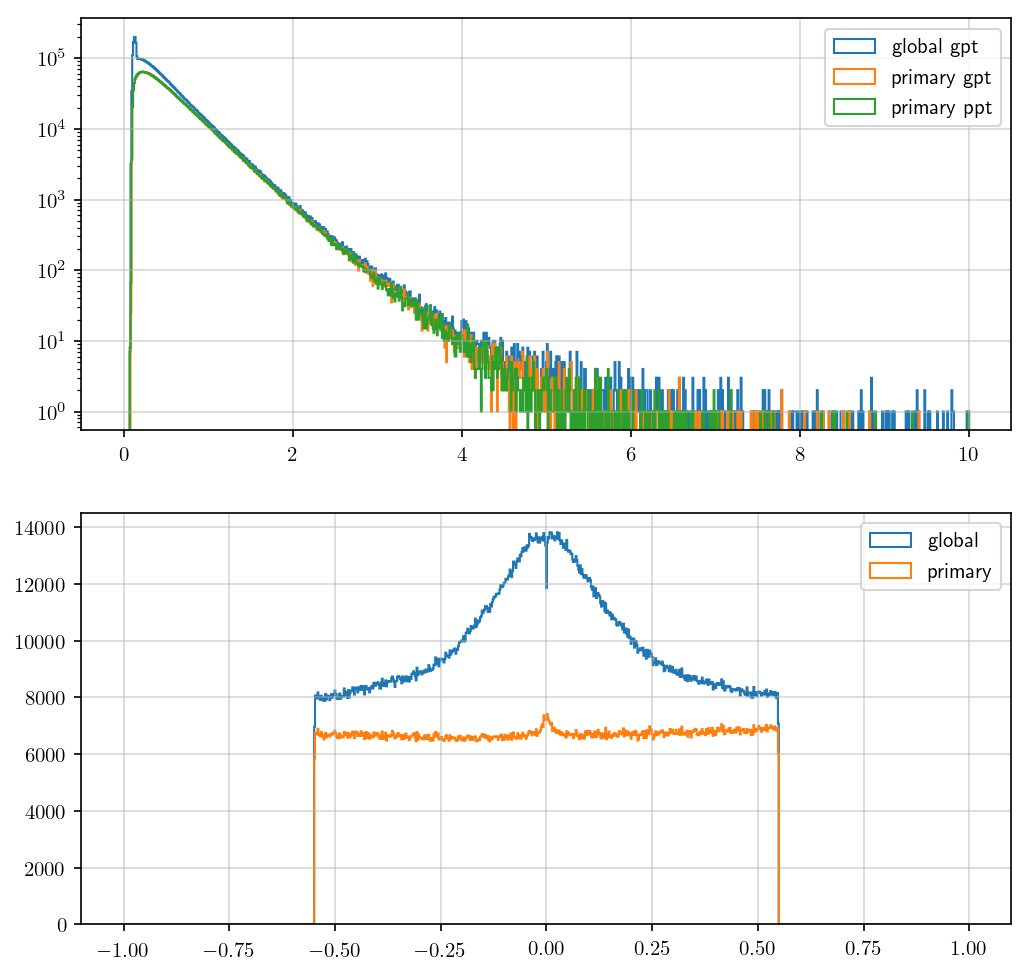

In [37]:
fig, ax = plt.subplots(2, figsize=(8, 4*2), dpi=150)

kwargs = dict(
    bins=np.linspace(0, 10, 1000),
    histtype='step'
)

ax[0].hist(df.gpt, label='global gpt', **kwargs)
ax[0].hist(df.loc[ is_primary ].gpt, label='primary gpt', **kwargs)
ax[0].hist(df.loc[ is_primary ].ppt, label='primary ppt', **kwargs)
ax[0].set_yscale('log')
ax[0].grid(alpha=0.5)
ax[0].legend()

kwargs = dict(
    bins=np.linspace(-1, 1, 1000),
    histtype='step'
)

ax[1].hist(df.teta, label='global', **kwargs)
ax[1].hist(df.loc[ is_primary ].teta, label='primary', **kwargs)
#ax[1].set_yscale('log')
ax[1].grid(alpha=0.5)
ax[1].legend()


plt.show()

In [38]:
#df.gpt.describe().map('{:,.3f}'.format)

## Position of the track "origin" for primary and global tracks

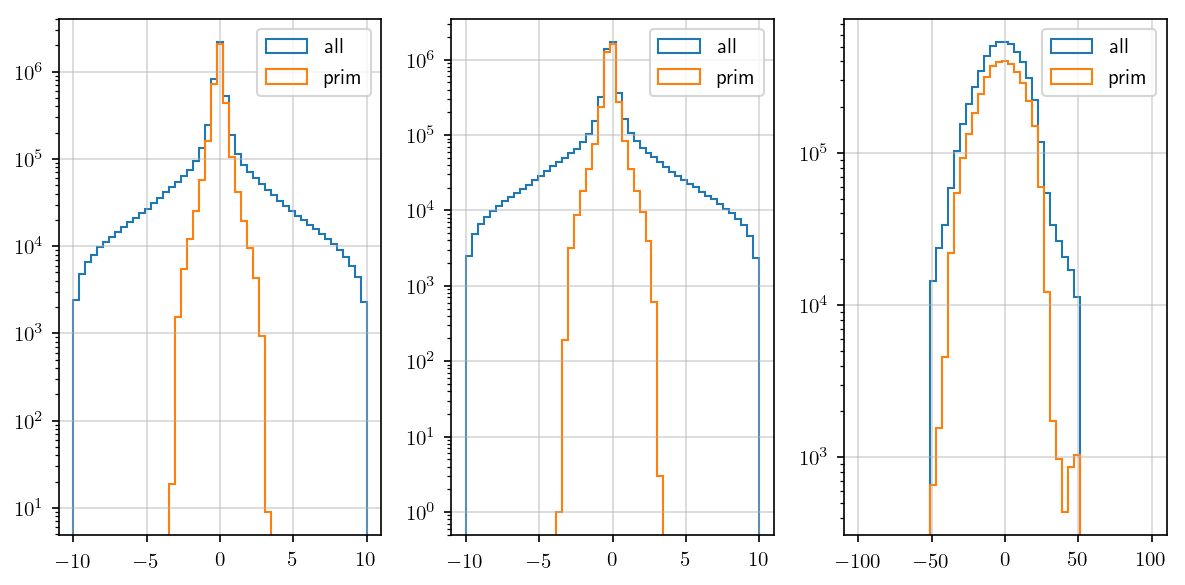

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4), dpi=150)
ax = ax.ravel()

oas = ['ox', 'oy', 'oz']
ranges = [
    dict(bins=np.linspace(-10, 10, 50)),
    dict(bins=np.linspace(-10, 10, 50)),
    dict(bins=np.linspace(-100, 100, 50))
]
ranges = dict(zip(oas, ranges))
kwargs = [dict(ranges[oa], histtype='step') for oa in oas]

for i, oa in enumerate(oas):
    a = ax[i]
    a.hist( df[oa], label='all', **kwargs[i])
    a.hist( df.loc[is_primary][oa], label='prim', **kwargs[i])
    a.grid(alpha=0.5)
    a.set_yscale('log')
    a.legend()
    
plt.tight_layout()
plt.show()

In [40]:
nbins_pt = 10
edges_pt = np.linspace(0.1, 1, 10)
edges_pt = np.append(edges_pt, np.inf)

Plot phi vs eta distributions for different P_T bins

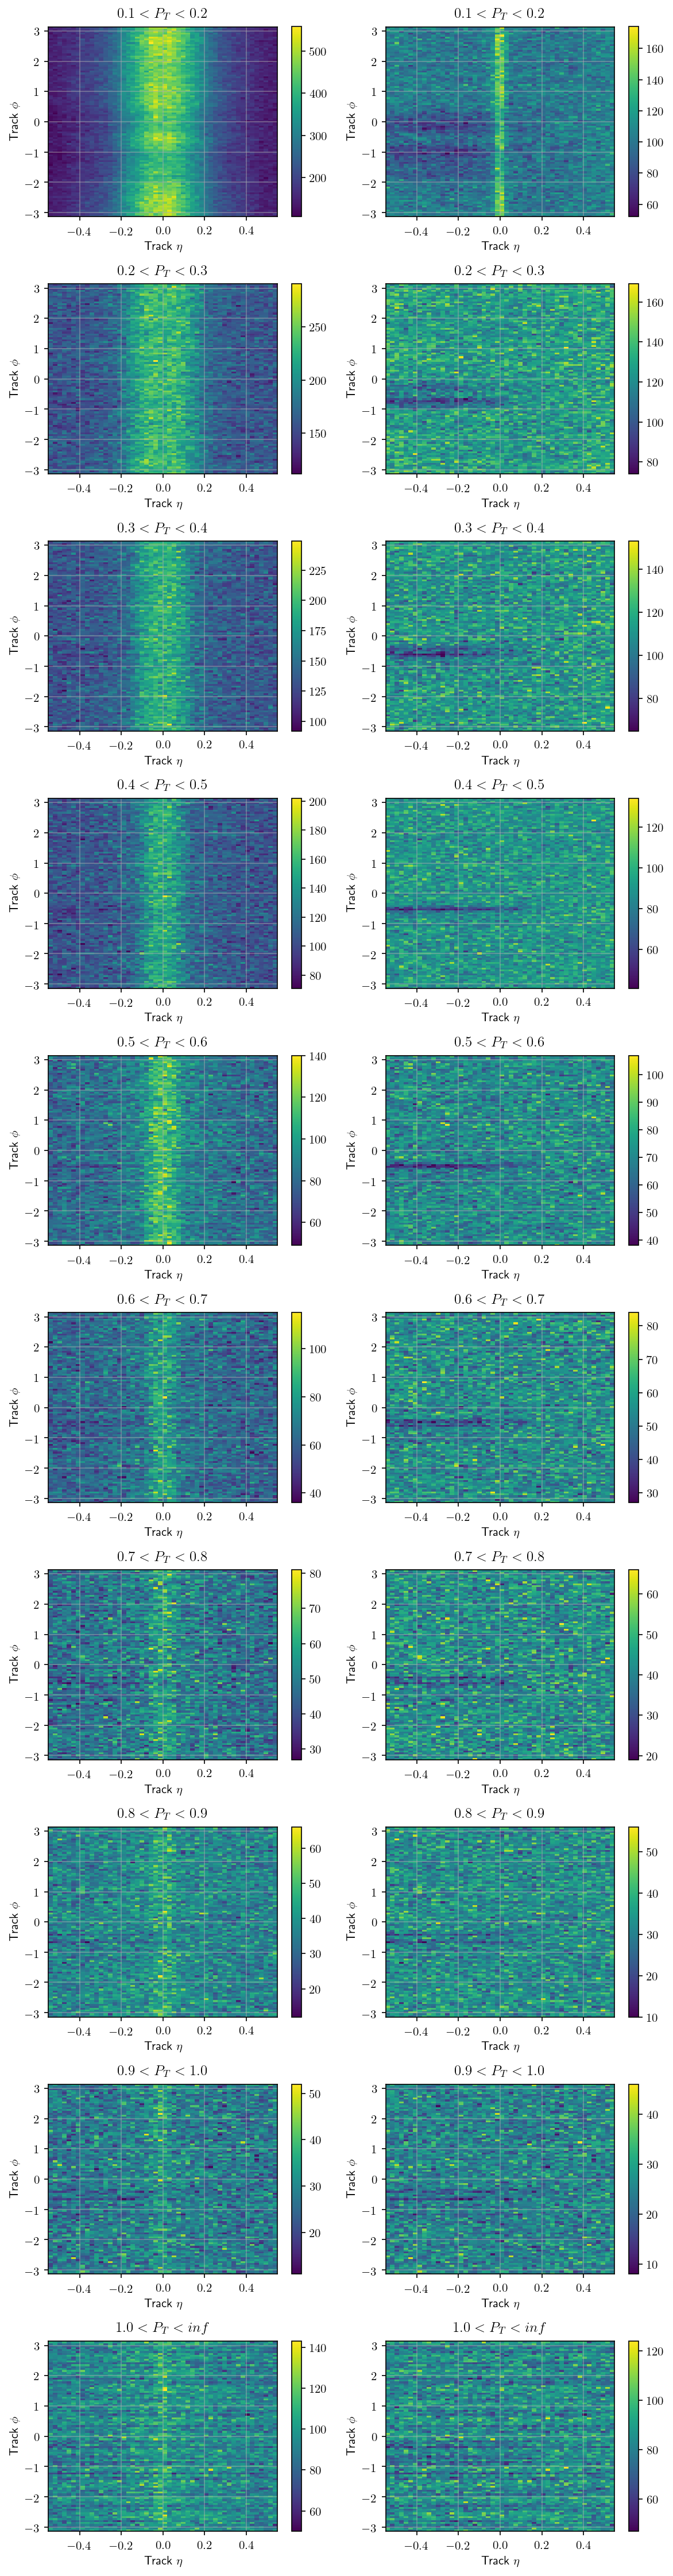

In [41]:
fig, ax = plt.subplots(10, 2, figsize=(8, 3*10), dpi=150)

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    #print(f'{i} bin: {pt_min:.1f} < P_T < {pt_max:.1f}')
    in_pt_bin = (df.gpt > pt_min) & (df.gpt < pt_max)
    
    a = ax[i, 0]
    h = a.hist2d(df.loc[ in_pt_bin ].teta, df.loc[ in_pt_bin ].tphi, bins=[50, 100]) 
    a.set_title(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.set_xlabel(r'Track $\eta$')
    a.set_ylabel(r'Track $\phi$')
    a.grid(alpha=0.5)
    fig.colorbar(h[3], ax=a)
    
    a = ax[i, 1]
    h = a.hist2d(df.loc[ is_primary & in_pt_bin ].teta, df.loc[ is_primary & in_pt_bin ].tphi, bins=[50, 100]) 
    a.set_title(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.set_xlabel(r'Track $\eta$')
    a.set_ylabel(r'Track $\phi$')
    a.grid(alpha=0.5)
    fig.colorbar(h[3], ax=a)

plt.tight_layout()
plt.show()

Plot phi distributions for different P_T bins and eta < 0 (East)

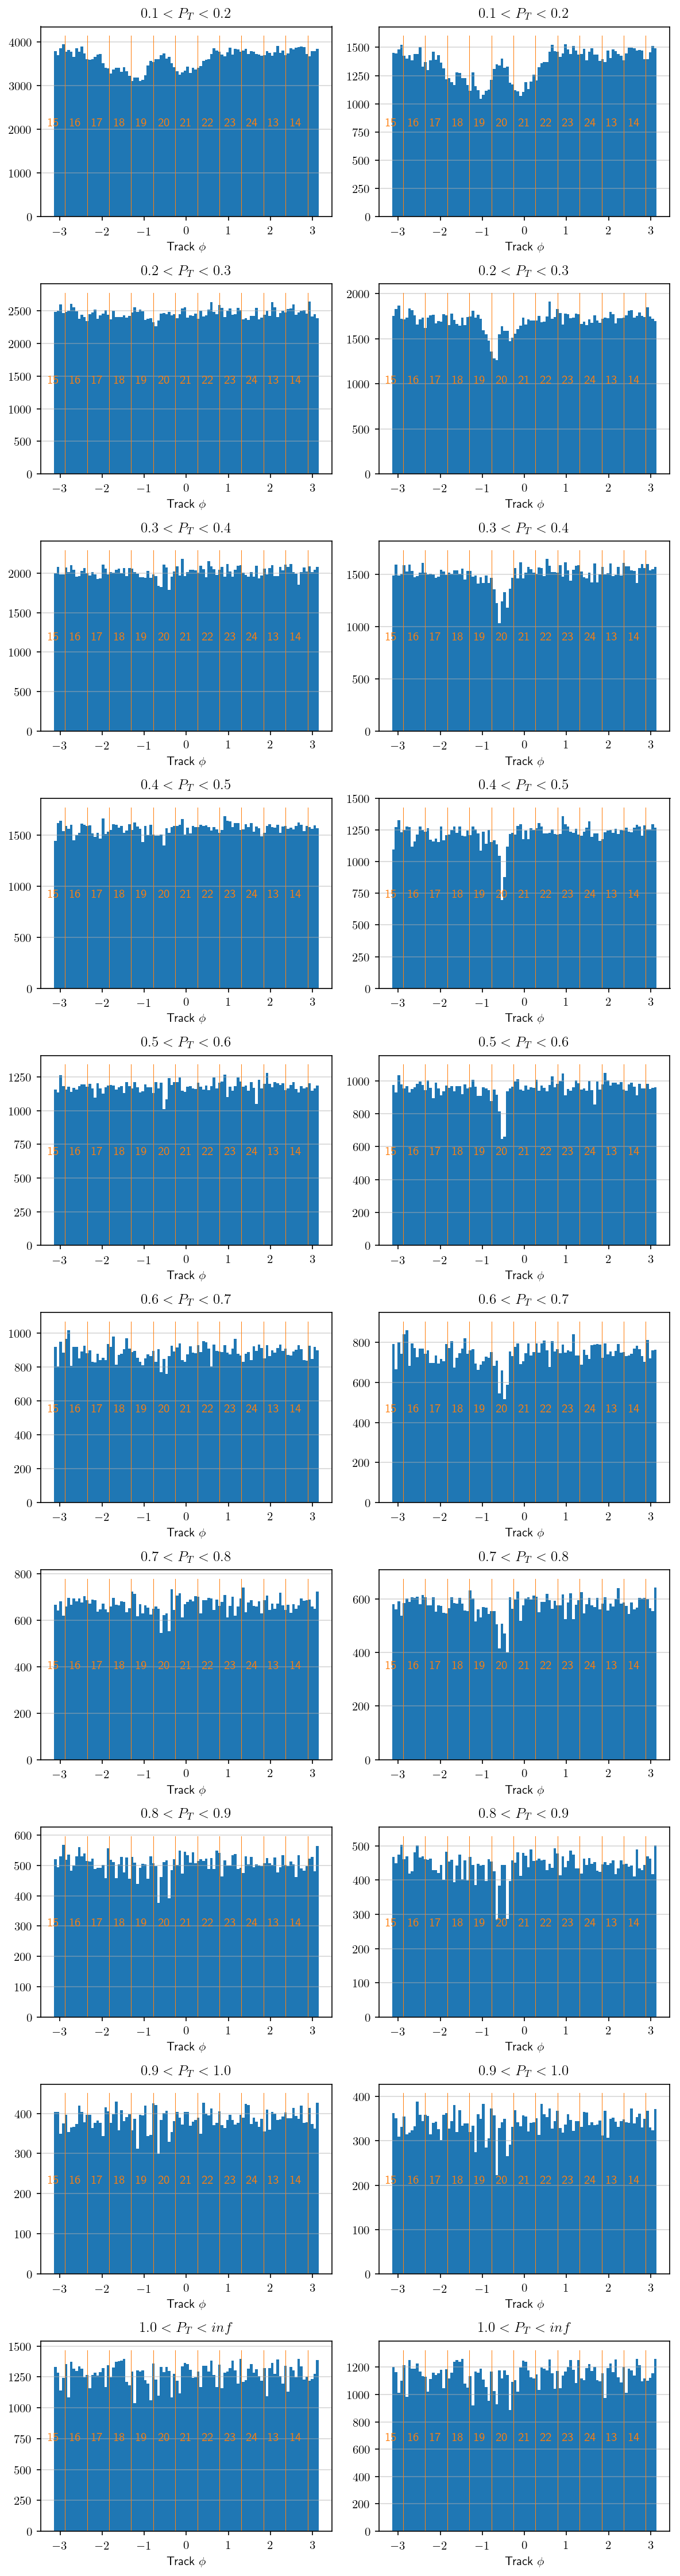

In [42]:
fig, ax = plt.subplots(10, 2, figsize=(8, 3*10), dpi=150)

for i, (pt_min, pt_max) in enumerate(zip(edges_pt, edges_pt[1:])):
    #print(f'{i} bin: {pt_min:.1f} < P_T < {pt_max:.1f}')
    in_pt_bin = (df.gpt > pt_min) & (df.gpt < pt_max)

    a = ax[i, 0]
    a.hist(df.loc[ points_east & in_pt_bin ].tphi, bins=100)
    a.set_title(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.set_xlabel(r'Track $\phi$')
    a.yaxis.grid(alpha=0.5)
    draw_tpc_edges(a)

    a = ax[i, 1]
    a.hist(df.loc[ is_primary & points_east & in_pt_bin ].tphi, bins=100)
    a.set_title(f'${pt_min:.1f} < P_T < {pt_max:.1f}$')
    a.set_xlabel(r'Track $\phi$')
    a.yaxis.grid(alpha=0.5)
    draw_tpc_edges(a)


plt.tight_layout()
plt.show()

Now look at the number of hits as a function of track azimuthal angle

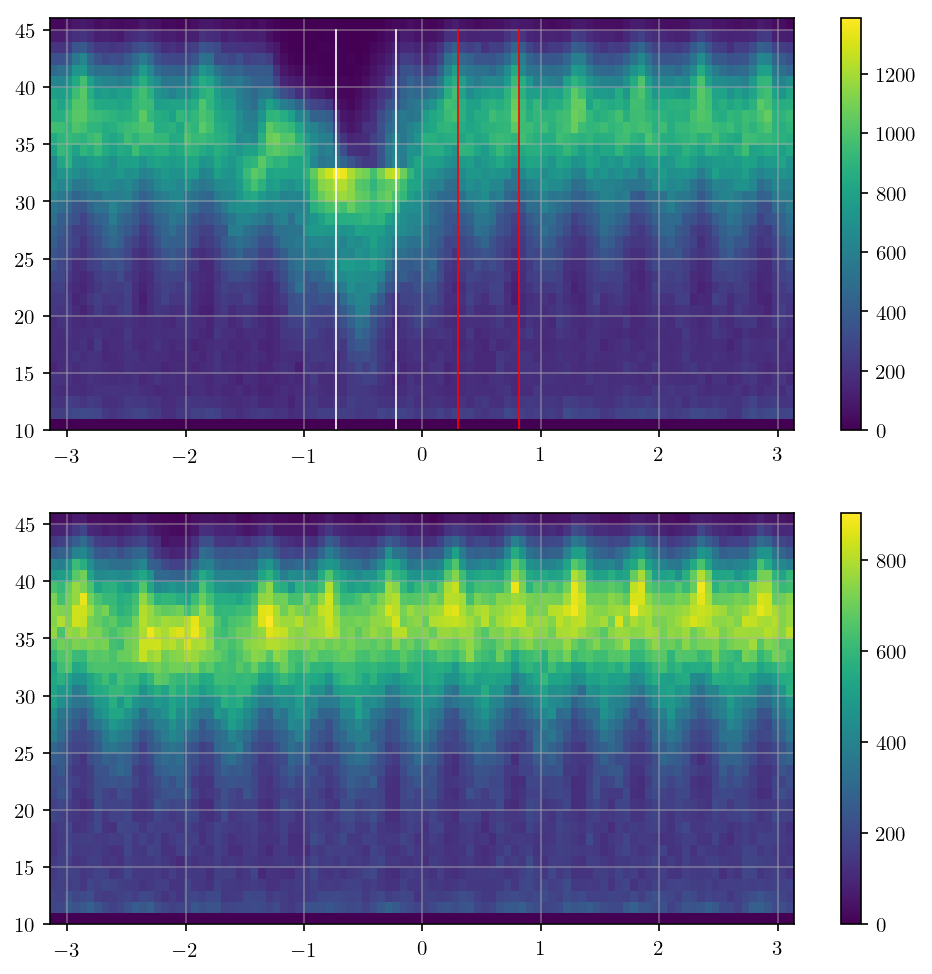

In [43]:
fig, (ax_east, ax_west) = plt.subplots(2, figsize=(8, 8), dpi=150)

h = ax_east.hist2d(df.loc[points_east].tphi, np.abs(df.loc[points_east].nhits),
                   bins=[100, np.arange(10, 47, 1)]) #, norm=mpl.colors.LogNorm())
ax_east.plot([-0.73, -0.73], [10, 45], 'w-', lw=0.8)
ax_east.plot([-0.22, -0.22], [10, 45], 'w-', lw=0.8)
ax_east.plot([0.3, 0.3], [10, 45], 'r-', lw=0.8)
ax_east.plot([0.82, 0.82], [10, 45], 'r-', lw=0.8)
ax_east.grid(alpha=0.5)

fig.colorbar(h[3], ax=ax_east)

h = ax_west.hist2d(df.loc[points_west].tphi, np.abs(df.loc[points_west].nhits),
                   bins=[100, np.arange(10, 47, 1)]) #, norm=mpl.colors.LogNorm())
ax_west.grid(alpha=0.5)

fig.colorbar(h[3], ax=ax_west)
plt.show()

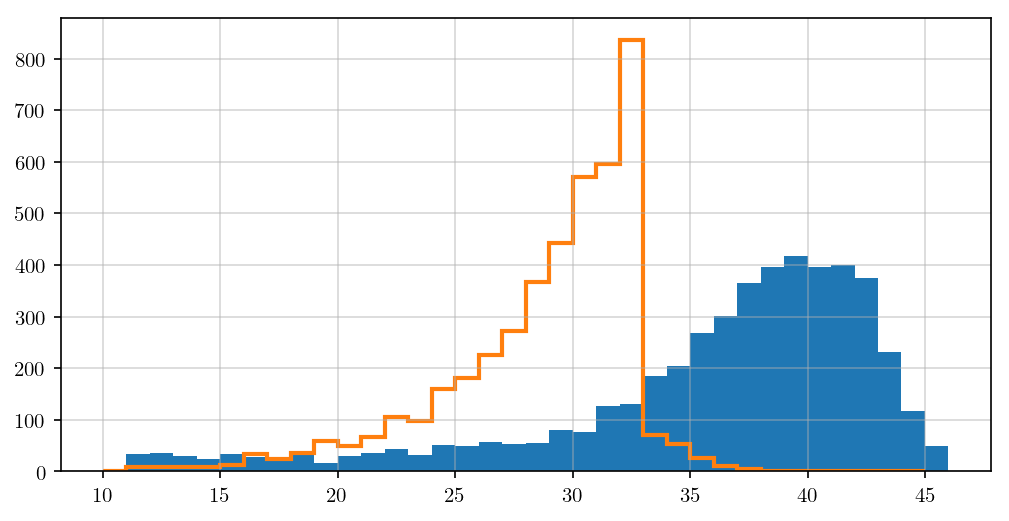

In [44]:
selection = (df.loc[points_east].tphi > 0.3) & \
            (df.loc[points_east].tphi < 0.82) & \
            (df.loc[points_east].ppt > 1)
        
df_god = df.loc[points_east].loc[ selection ]

selection = (df.loc[points_east].tphi > -0.73 ) & \
            (df.loc[points_east].tphi < -0.22 ) & \
            (df.loc[points_east].ppt > 1) 
         
df_bad = df.loc[points_east].loc[ selection ]

#ws = np.ones_like(df_bad.nhits.values, dtype='float32')
#ws *= 0.6
ws = None

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
h_god, dummy, dummy = ax.hist(df_god.nhits, bins=np.arange(10, 47, 1))
h_bad, dummy, dummy = ax.hist(df_bad.nhits, bins=np.arange(10, 46, 1), weights=ws, histtype='step', lw=2)
plt.grid(alpha=0.5)
plt.show()

In [45]:
print(h_god[:].sum())
print(h_bad[:].sum())

print(h_god[0:6].sum())
print(h_bad[0:6].sum())

print(h_god[-12:])
print(h_bad[-12:])

4785.0
4333.0
156.0
46.0
[205. 269. 301. 365. 396. 418. 397. 400. 375. 231. 117.  49.]
[71. 54. 26. 11.  4.  0.  1.  0.  0.  1.  0.  0.]


## Vertex position vs track origin

In [46]:
# need to add a condition to exec only once
df_god.index = df_god.index.droplevel(2)
df_v.index = df_v.index.droplevel(2)

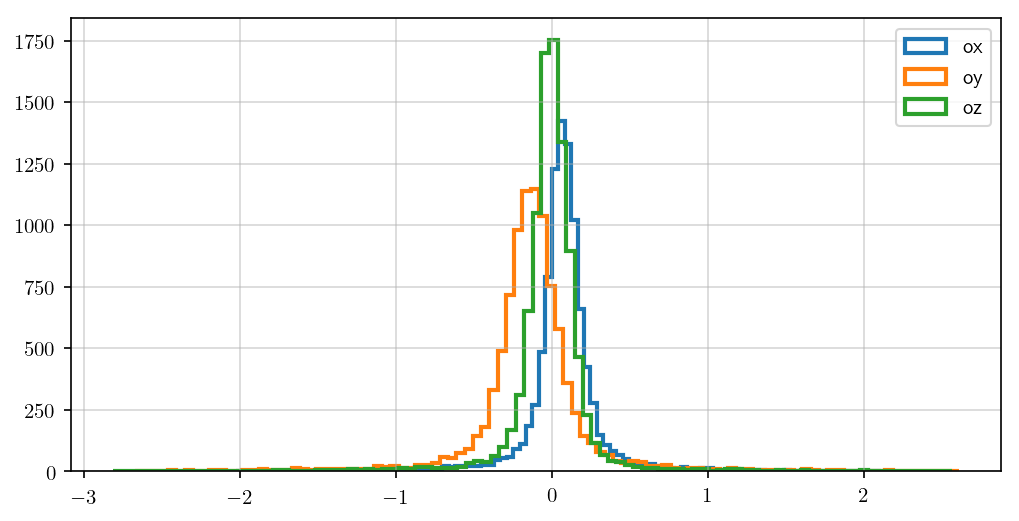

In [47]:
ccc = ['ox', 'oy', 'oz']

df_v.columns = ccc

df_t2v = df_god[ccc] - df_v.loc[df_god.index]

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.hist(df_t2v.ox, bins=100, histtype='step', lw=2)
ax.hist(df_t2v.oy, bins=100, histtype='step', lw=2)
ax.hist(df_t2v.oz, bins=100, histtype='step', lw=2)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

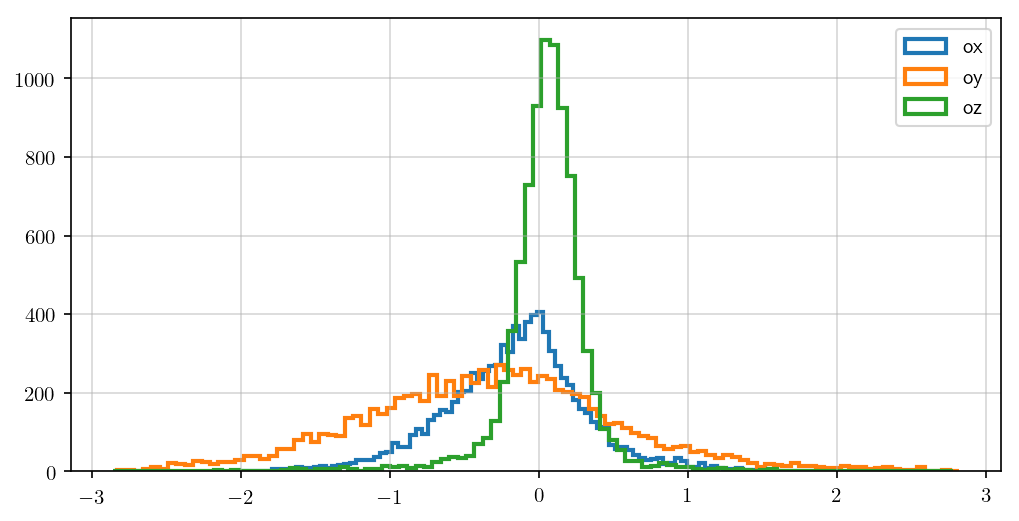

In [48]:
ccc = ['ox', 'oy', 'oz']

df_v.columns = ccc

df_t2v = df_bad[ccc] - df_v.loc[df_bad.index]

fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
ax.hist(df_t2v.ox, bins=100, histtype='step', lw=2)
ax.hist(df_t2v.oy, bins=100, histtype='step', lw=2)
ax.hist(df_t2v.oz, bins=100, histtype='step', lw=2)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [49]:
#df_v.loc[df_god.index]

Track chi2

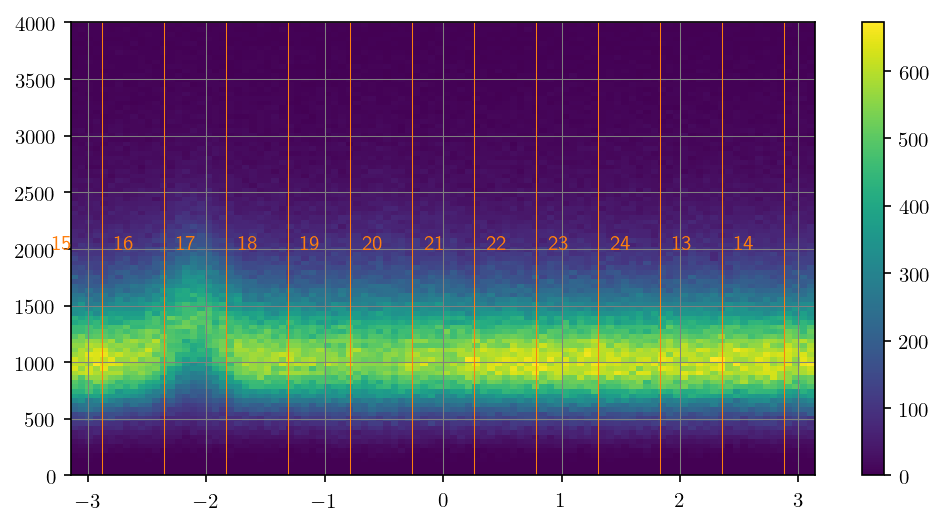

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=150)
ax.grid(linestyle='-', linewidth='0.5', color='grey')
plt.hist2d(df.loc[points_east].tphi, np.abs(df.loc[points_east].chi2), bins=[100, np.linspace(0, 4000, 100)])
plt.colorbar()
plt.grid(True)
draw_tpc_edges(ax)
plt.show()